For the implementation and training of the netwrok, I used this [tutorial](https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/) as a reference

In [1]:
# imports 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential 
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator 
import glob
import cv2
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt


# Set params

In [2]:
image_size=256
train_dir='/content/drive/My Drive/images/train'
validation_dir='/content/drive/My Drive/images/validation'

# Load the pre-trained net

In [3]:
vgg_conv=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size,image_size,3)
)

58892288/58889256 [==============================] - 1s 0us/step


In [4]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

# Create our new net

In [5]:
# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
# for layer in vgg_conv.layers:
#     print(layer, layer.trainable)

In [6]:
# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2097216   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 16,811,969
Trainable params: 2,097,281
Non-trainable params: 14,714,688
_________________________________________________________________


# Setup the data generators


In [7]:
imgs=[]
labels=[]
image_paths=glob.glob("/content/drive/My Drive/images/*/*")
for image_path in image_paths:
  imgs.append(cv2.resize(cv2.imread(image_path),(image_size,image_size))/255)
  labels.append(image_path.split(os.sep)[-2])
imgs=np.array(imgs)
labels=np.array(labels)
lb=preprocessing.LabelBinarizer()
labels=lb.fit_transform(labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, 
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42)

# Train the model

In [9]:
# Configure the model for training
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['acc'])

# Train the model
history = model.fit(
      X_train,
      y_train,
      batch_size=1,
      epochs=10,
      validation_data=(X_test, y_test),
      verbose=2)

Epoch 1/10
111/111 - 4s - loss: 1.1832 - acc: 0.6036 - val_loss: 3.2788 - val_acc: 0.6667
Epoch 2/10
111/111 - 4s - loss: 0.9527 - acc: 0.7387 - val_loss: 0.5756 - val_acc: 0.8958
Epoch 3/10
111/111 - 4s - loss: 0.4969 - acc: 0.8919 - val_loss: 0.6143 - val_acc: 0.8542
Epoch 4/10
111/111 - 4s - loss: 0.4598 - acc: 0.9279 - val_loss: 0.4861 - val_acc: 0.9375
Epoch 5/10
111/111 - 4s - loss: 0.3938 - acc: 0.9550 - val_loss: 0.4957 - val_acc: 0.9167
Epoch 6/10
111/111 - 4s - loss: 0.3529 - acc: 0.9910 - val_loss: 0.4973 - val_acc: 0.8125
Epoch 7/10
111/111 - 4s - loss: 0.3224 - acc: 1.0000 - val_loss: 0.4865 - val_acc: 0.8125
Epoch 8/10
111/111 - 4s - loss: 0.3046 - acc: 1.0000 - val_loss: 0.5503 - val_acc: 0.7500
Epoch 9/10
111/111 - 4s - loss: 0.2915 - acc: 1.0000 - val_loss: 0.4067 - val_acc: 0.9167
Epoch 10/10
111/111 - 4s - loss: 0.2742 - acc: 1.0000 - val_loss: 0.4603 - val_acc: 0.8125


(array(['bg'], dtype='<U14'), <matplotlib.image.AxesImage at 0x7f0a5d60d320>)

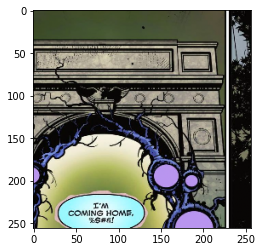

In [11]:
p=model.predict(np.expand_dims(X_test[15],0))
lb.inverse_transform(round(p[0][0])),plt.imshow(X_test[15])

# Check performance

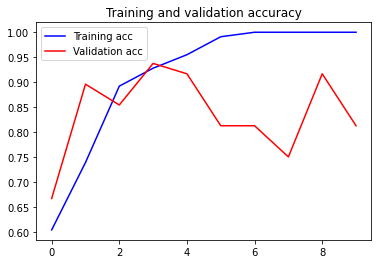

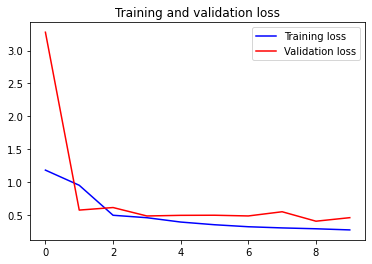

In [12]:
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# Run the function to illustrate accuracy and loss
visualize_results(history)